In [49]:
import pandas as pd
import re
import math
import time
import random
import matplotlib.pyplot as plt
import numpy as np

from deap import algorithms, base, creator, tools

In [50]:
# TSPLIB file reader
def read_tsplib_file(filename):
    if filename is None:
        raise FileNotFoundError('Filename can not be None')
    with open(filename) as file:
        lines = file.readlines()
        data = [line.lstrip() for line in lines if line != ""]
        dimension = re.compile(r'[^\d]+')
        for item in data:
            if item.startswith('DIMENSION'):
                dimension = int(dimension.sub('', item))
                break
        c = [-1.0] * (2 * dimension)
        cities_coord = []
        for item in data:
            if item[0].isdigit():
                j, coordX, coordY = [float(x.strip()) for x in item.split(' ')]
                c[2 * (int(j) - 1)] = coordX
                c[2 * (int(j) - 1) + 1] = coordY
                cities_coord.append([coordX, coordY])
        cities = pd.DataFrame(cities_coord)
        #         cities = cities_coord
        matrix = [[-1] * dimension for _ in range(dimension)]
        for k in range(dimension):
            matrix[k][k] = 0
            for j in range(k + 1, dimension):
                dist = math.sqrt((c[k * 2] - c[j * 2]) ** 2 + (c[k * 2 + 1] - c[j * 2 + 1]) ** 2)
                dist = round(dist)
                matrix[k][j] = dist
                matrix[j][k] = dist
        return matrix, dimension, cities

In [51]:
problem_name = 'Qatar 194 TSP'
optimal_fitness = 9352
dist_matrix, nb_cities, cities_coord = read_tsplib_file('./qa194.tsp')

In [52]:
def create_clusters(X):
    from sklearn.cluster import KMeans
    clusters = 14
    km = KMeans(
        n_clusters=clusters, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    y = km.fit_predict(X)
    kc = km.cluster_centers_
    return y,kc

In [53]:
Klusters, Kcenters = create_clusters(cities_coord)

In [54]:
def plot_clusters(X,Y,C):
    plt.figure(figsize=(10,10))
    for k in range(np.unique(Y).shape[0]):
        plt.scatter(X[Y==k][0],X[Y==k][1])
        plt.scatter(C[k, 0], C[k, 1],marker='*',c='red')
        plt.text(C[k, 0], C[k, 1],str(k), fontsize=12)
    plt.axis('scaled')
    plt.show()

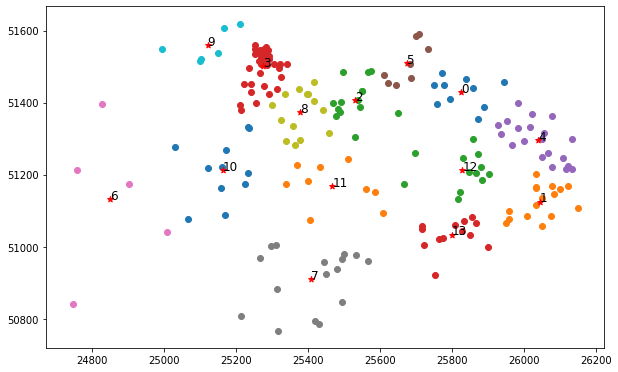

In [55]:
plot_clusters(cities_coord, Klusters, Kcenters)

In [81]:
def evalTSP(individual, dist_mat):
    distance = dist_mat[individual[-1]][individual[0]]
    for gene1, gene2 in zip(individual[0:-1], individual[1:]):
        distance += dist_mat[gene1][gene2]
    return distance,

In [237]:
def create_toolbox(num_cities, ind_mutpb, tourn_size, matrix):
    tb = base.Toolbox()

    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, typecode='i', fitness=creator.FitnessMin)
    
    tb.register("indices", np.random.permutation, num_cities)
    
    tb.register("individual", tools.initIterate, creator.Individual, tb.indices)
    tb.register("population", tools.initRepeat, list, tb.individual)

    tb.register("mate", tools.cxOrdered)
    tb.register("mutate", tools.mutShuffleIndexes, indpb=ind_mutpb) 
    tb.register("select", tools.selTournament, tournsize=tourn_size) 
    tb.register("evaluate", evalTSP, dist_mat=matrix)
    return tb

In [83]:
def create_stats():
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register('min', np.min)
    return stats

In [84]:
def create_dist_mat(cityList):
    dimension = cityList.shape[0]
    matrix = [[-1] * dimension for _ in range(dimension)]
    for k in range(dimension):
        matrix[k][k] = 0
        for j in range(k + 1, dimension):
            dist = math.sqrt((cityList[k,0] - cityList[j,0]) ** 2 + (cityList[k,1] - cityList[j,1]) ** 2)
            dist = round(dist)
            matrix[k][j] = dist
            matrix[j][k] = dist
    return matrix

In [324]:
# solve kcenters optimal path

def ga_cluster(citylist):

    m0 = create_dist_mat(citylist)
    l0 = citylist.shape[0]
    
    pop_size = 4*l0
    nb_generations = 200
    cross_prob = 0.85        
    mut_prob = 0.2         
    indep_mut_prob = 1/l0
    tournament_size = 3    
    toolbox = create_toolbox(num_cities=l0, ind_mutpb = 1 / indep_mut_prob, tourn_size=tournament_size, matrix=m0)
    fit_stats = create_stats()
    random.seed(37)
    pop = toolbox.population(n=pop_size)
    hof = tools.HallOfFame(1)
    result, log = algorithms.eaSimple(pop, 
                                      toolbox, 
                                      cxpb=cross_prob, 
                                      mutpb=mut_prob, 
                                      ngen=nb_generations, 
                                      verbose=False, 
                                      stats=fit_stats, 
                                      halloffame=hof)
    
    fitness = evalTSP(hof[0], m0)[0]
    print(fitness)
    print(hof[0])
    # graph fitness
#     plt.plot(log.select('min'), 'c-')
#     plt.ylabel('Fitness');
#     plt.xlabel('Generations');
#     plt.show()

#     # graph show path
    xlist = [citylist[i,0] for i in hof[0]]
    ylist = [citylist[i,1] for i in hof[0]]

    xlist.append(xlist[0])
    ylist.append(ylist[0])

    plt.figure(figsize=(10,10))
#     for k in range(np.unique(Klusters).shape[0]):
#         plt.scatter(cities_coord[Klusters==k][0],cities_coord[Klusters==k][1])

    for idx,city in enumerate(citylist):
        plt.scatter(city[0],city[1],marker='*',c='red')
        plt.text(city[0], city[1], str(idx), fontsize=10)

    plt.plot(xlist, ylist, linestyle='-',c='red')

    plt.axis('scaled')
    plt.show()

    return hof[0]

/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


3484
[0, 4, 1, 12, 13, 7, 11, 10, 6, 9, 3, 8, 2, 5]


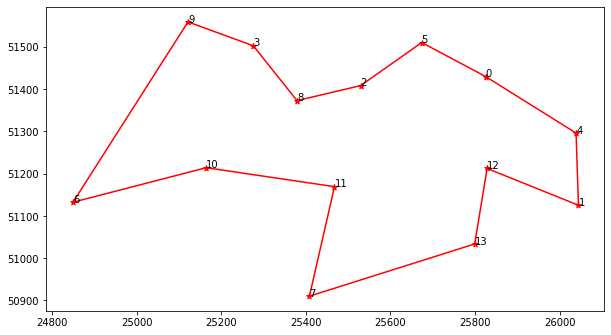

In [325]:
p = {}
p['centers'] = ga_cluster(Kcenters)

0
564
[5, 2, 3, 0, 1, 4, 7, 8, 9, 6]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


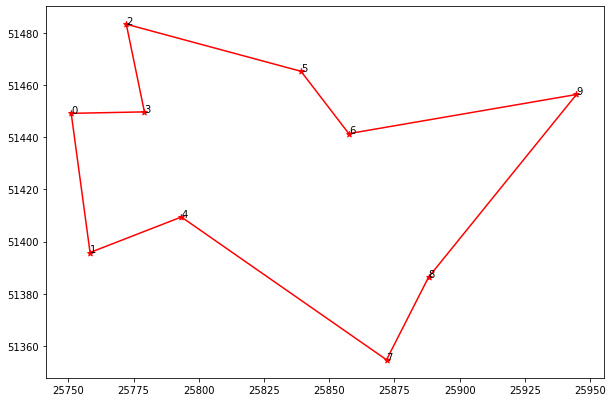

4
882
[8, 14, 11, 10, 12, 9, 19, 15, 16, 18, 17, 13, 6, 3, 1, 0, 2, 5, 7, 4]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


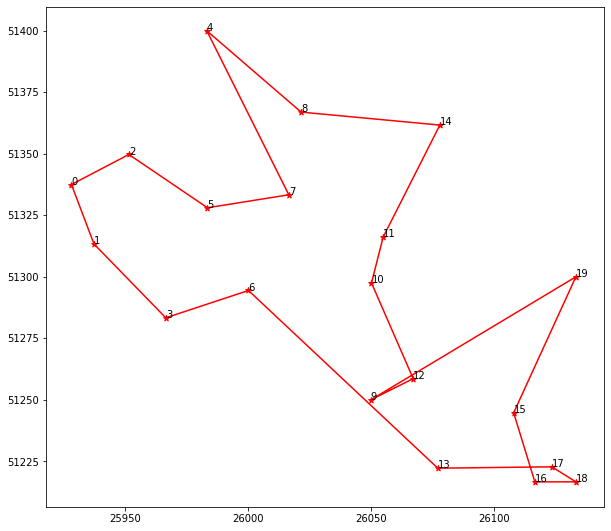

1


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


737
[13, 12, 14, 15, 10, 8, 4, 3, 1, 0, 2, 6, 5, 7, 11, 9]


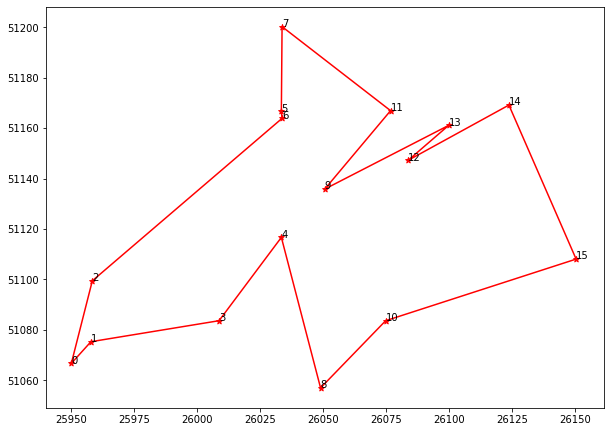

12
745
[9, 8, 6, 4, 1, 0, 2, 3, 11, 10, 5, 7]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


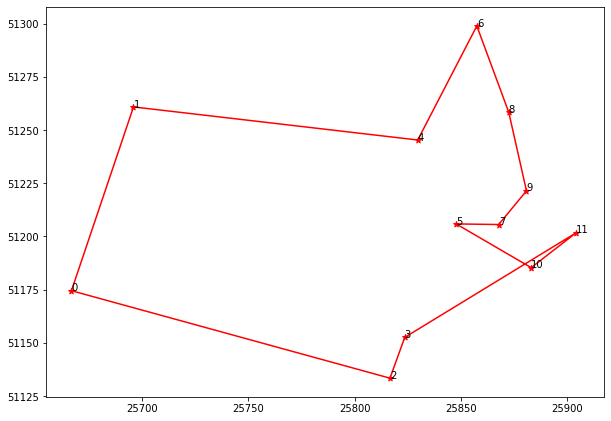

13
655
[6, 11, 10, 8, 7, 9, 12, 3, 2, 1, 0, 4, 5]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


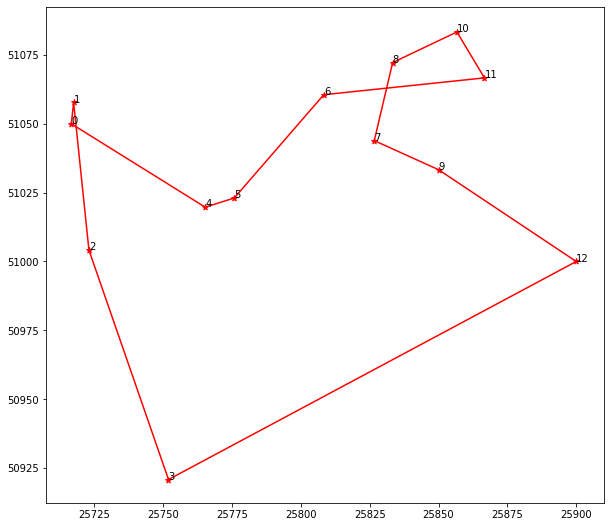

7
1125
[11, 7, 6, 5, 0, 4, 1, 3, 2, 8, 13, 15, 14, 12, 10, 9]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


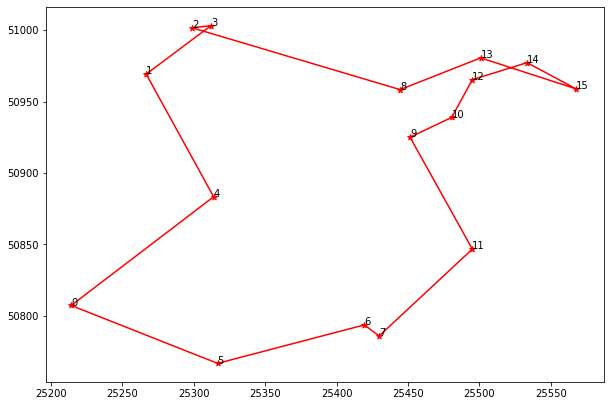

11
757
[1, 0, 3, 8, 7, 6, 5, 4, 2]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


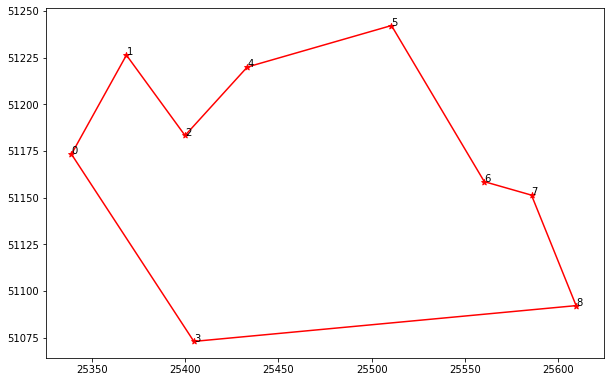

10
954
[9, 7, 2, 0, 1, 5, 3, 4, 6, 8, 10]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


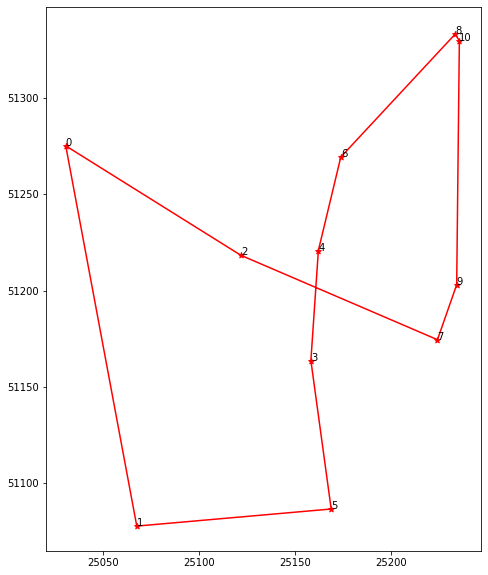

6
1301
[2, 3, 4, 0, 1]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


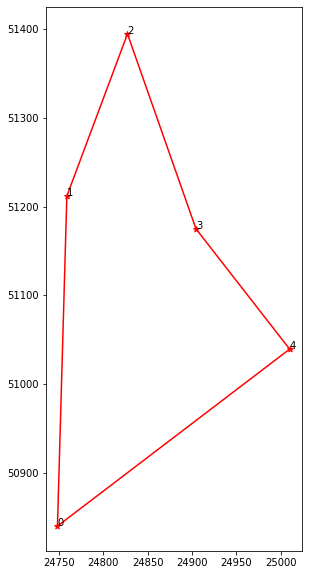

9
492

/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



[1, 2, 3, 5, 4, 0]


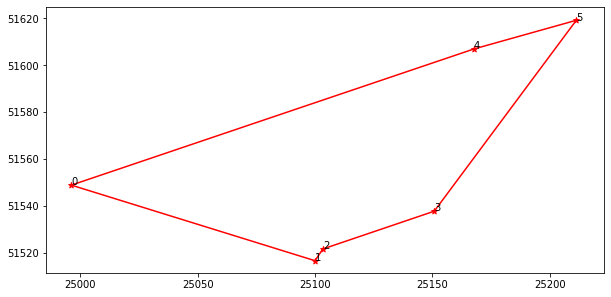

3


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


901
[25, 30, 24, 19, 11, 6, 8, 7, 3, 12, 38, 36, 37, 39, 35, 32, 20, 9, 4, 1, 0, 2, 5, 10, 18, 23, 28, 29, 27, 31, 22, 33, 34, 26, 14, 15, 13, 21, 16, 17]


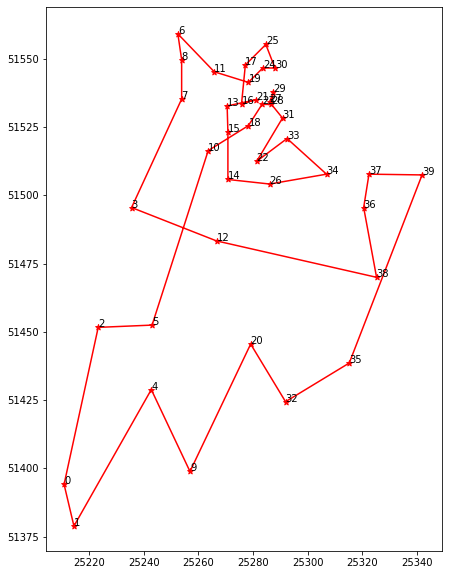

8
562
[5, 3, 4, 1, 0, 2, 6, 11, 9, 8, 10, 12, 13, 7]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


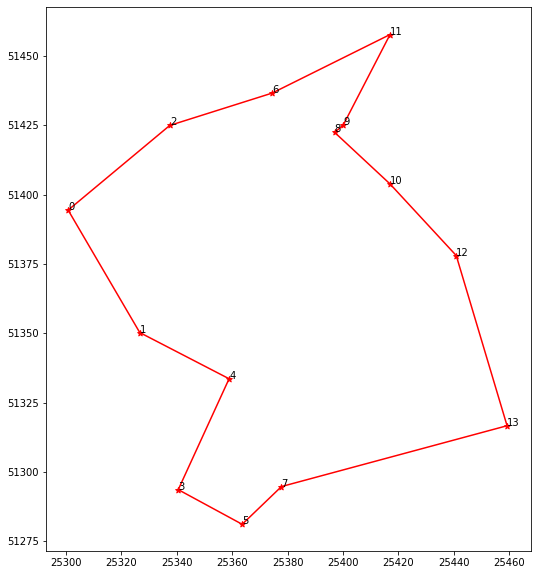

2
699
[8, 13, 6, 2, 1, 3, 4, 0, 5, 11, 12, 10, 9, 7]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


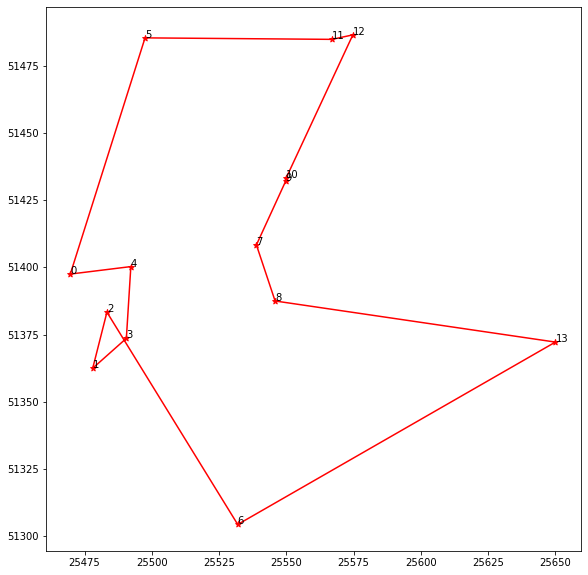

5
399
[7, 3, 4, 2, 1, 0, 5, 6]


/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/terman37/miniconda3/envs/meta/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


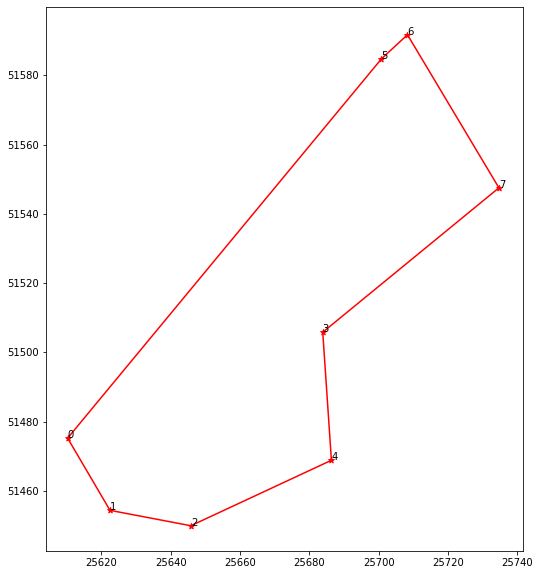

In [326]:
for c in p['centers']:
    newcitylist = cities_coord[Klusters==c].to_numpy()
    print(c)
    p['K-'+str(c)] = ga_cluster(newcitylist)

KeyError: ('centers', 0)

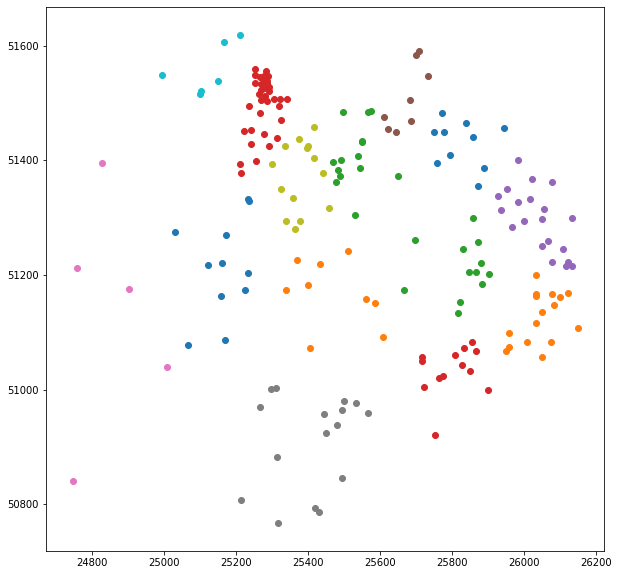

In [329]:


    plt.figure(figsize=(10,10))
    for k in range(np.unique(Klusters).shape[0]):
        plt.scatter(cities_coord[Klusters==k][0],cities_coord[Klusters==k][1])

    #     # graph show path
    for solution in p.items():
    
        xlist = [cities_coord[i,0] for i in solution]
        ylist = [cities_coord[i,1] for i in solution]

        xlist.append(xlist[0])
        ylist.append(ylist[0])
        
#     for idx,city in enumerate(citylist):
#         plt.scatter(city[0],city[1],marker='*',c='red')
#         plt.text(city[0], city[1], str(idx), fontsize=10)

        plt.plot(xlist, ylist, linestyle='-',c='red')

    plt.axis('scaled')
    plt.show()